In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy

import scoobpsf
import scoobpsf.ad_scoob as ad_scoob
import scoobpsf.props as props
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

import lina

from importlib import reload

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

from scipy.signal import windows
from scipy.optimize import minimize

wavelength = 650e-9*u.m
pupil_diam = 9.4*u.mm
lyot_stop_diam = 8.6*u.mm

crad = 34/2 * 9.4/10.2 * 8.6/9.4

def create_control_mask(iwa=3, owa=12, edge=None, rotation=0):
    x = (xp.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*psf_pixelscale_lamD
    x,y = xp.meshgrid(x,x)
    r = xp.hypot(x, y)
    control_mask = (r < owa) * (r > iwa)
    if edge is not None: control_mask *= (x > edge)

    control_mask = _scipy.ndimage.rotate(control_mask, rotation, reshape=False, order=0)
    return control_mask

# Establish the forward model parameters.

916


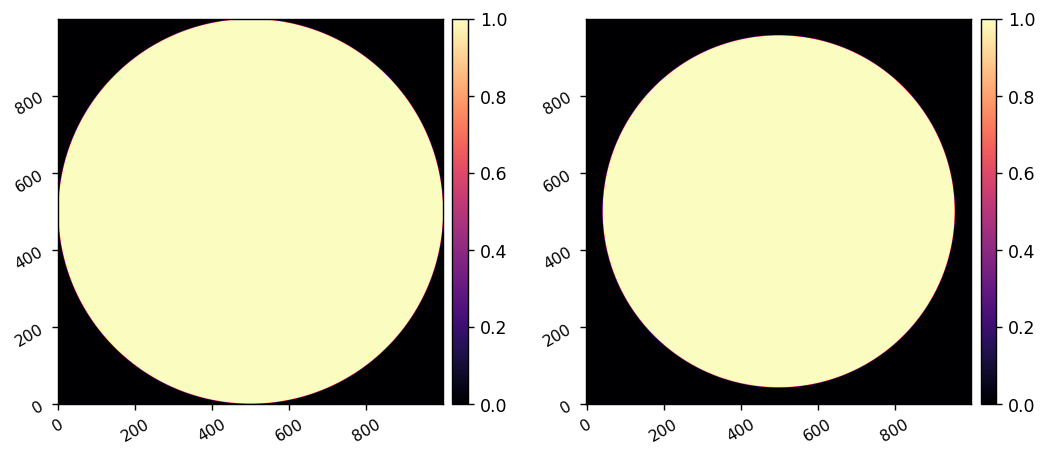

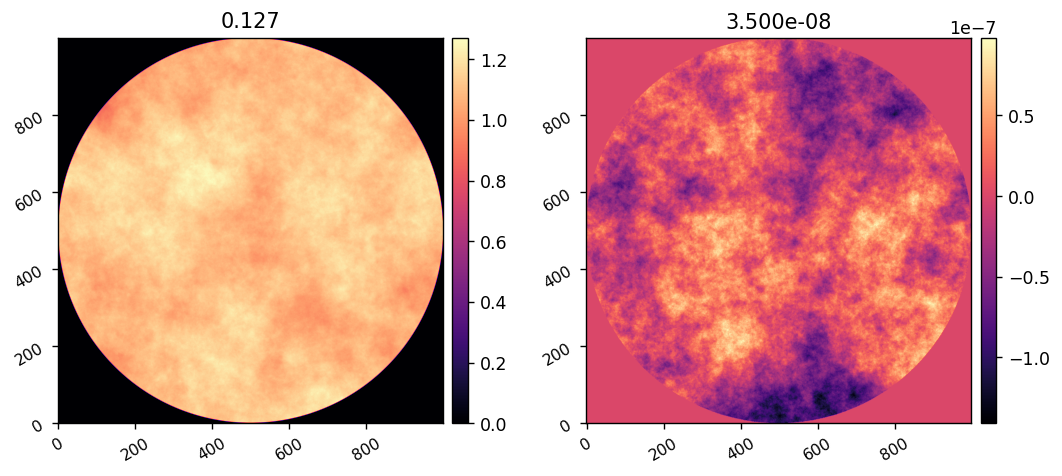

In [2]:
npix = 1000
oversample = 2.048
N = int(npix*oversample)

nlyot = int(np.ceil(lyot_stop_diam/pupil_diam * npix))
if nlyot%2==1:
    nlyot += 1
print(nlyot)

import poppy
pwf = poppy.FresnelWavefront(beam_radius=pupil_diam/2, npix=npix, oversample=1) # pupil wavefront
APERTURE = poppy.CircularAperture(radius=pupil_diam/2).get_transmission(pwf)
LYOT = poppy.CircularAperture(radius=lyot_stop_diam/2).get_transmission(pwf)
imshow2(APERTURE, LYOT)

reload(utils)
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                # opd_seed=12, amp_seed=1234,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')

### Initialize DM parameters

31.914893617021274
952


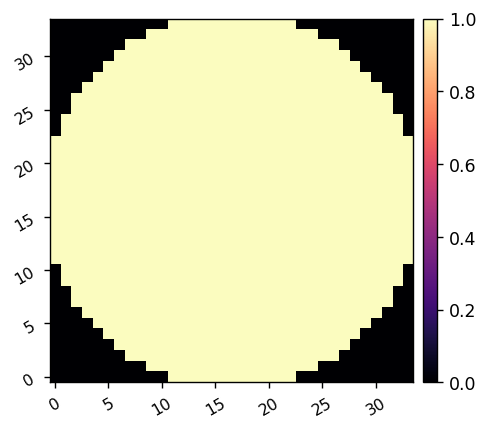

1148


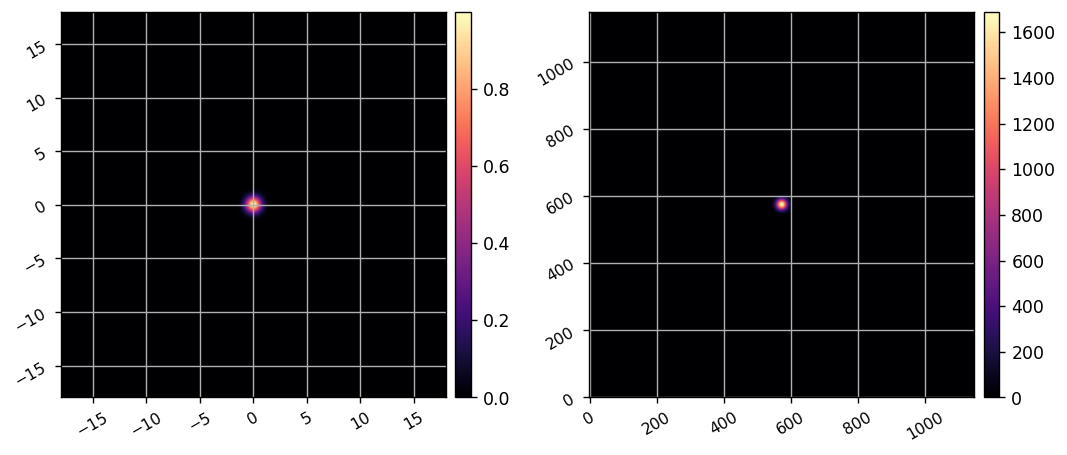

In [3]:
Nact = 34
act_spacing = 0.3*u.mm
inf_sampling = (npix/pupil_diam * act_spacing).value
print(inf_sampling)

dm_mask = xp.ones((Nact,Nact), dtype=bool)
xx = (xp.linspace(-Nact//2, Nact//2 - 1, Nact) + 1/2)
x,y = xp.meshgrid(xx,xx)
r = xp.sqrt(x**2 + y**2)
dm_mask[r>(Nact/2 + 1/2)] = 0
Nacts = int(xp.sum(dm_mask))
print(Nacts)
imshow1(dm_mask)

reload(ad_scoob)
inf_fun = ad_scoob.make_gaussian_inf_fun(act_spacing=act_spacing, sampling=inf_sampling, 
                                         Nacts_per_inf=Nact + 2, # number of influence functions across the grid
                                         coupling=0.15,)

Nsurf = inf_fun.shape[0]
print(Nsurf)

# fourier_inf_fun = xp.fft.fft2(inf_fun)
# imshow2(inf_fun, xp.abs(xp.fft.fftshift(fourier_inf_fun)), pxscl1=1/inf_sampling, grid=True, lognorm2=True, vmin2=1e-4)
fourier_inf_fun = xp.fft.fftshift(xp.fft.fft2(xp.fft.ifftshift(inf_fun,)))
imshow2(inf_fun, xp.abs(fourier_inf_fun), pxscl1=1/inf_sampling, grid=True)

# DM command coordinates
xc = inf_sampling*(xp.linspace(-Nact//2, Nact//2-1, Nact) + 1/2)
yc = inf_sampling*(xp.linspace(-Nact//2, Nact//2-1, Nact) + 1/2)

# Influence function frequncy sampling
fx = xp.fft.fftshift(xp.fft.fftfreq(Nsurf))
fy = xp.fft.fftshift(xp.fft.fftfreq(Nsurf))

# forward DM model MFT matrices
Mx_dm = xp.exp(-1j*2*np.pi*xp.outer(fx,xc))
My_dm = xp.exp(-1j*2*np.pi*xp.outer(yc,fy))

Mx_dm_back = xp.exp(1j*2*np.pi*xp.outer(xc,fx))
My_dm_back = xp.exp(1j*2*np.pi*xp.outer(fy,yc))

### Initialize vortex mask parameters.

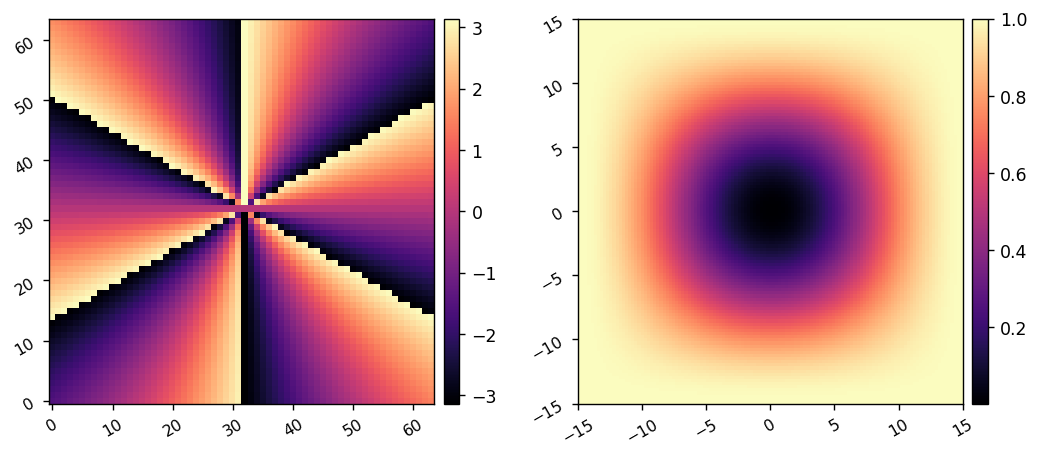

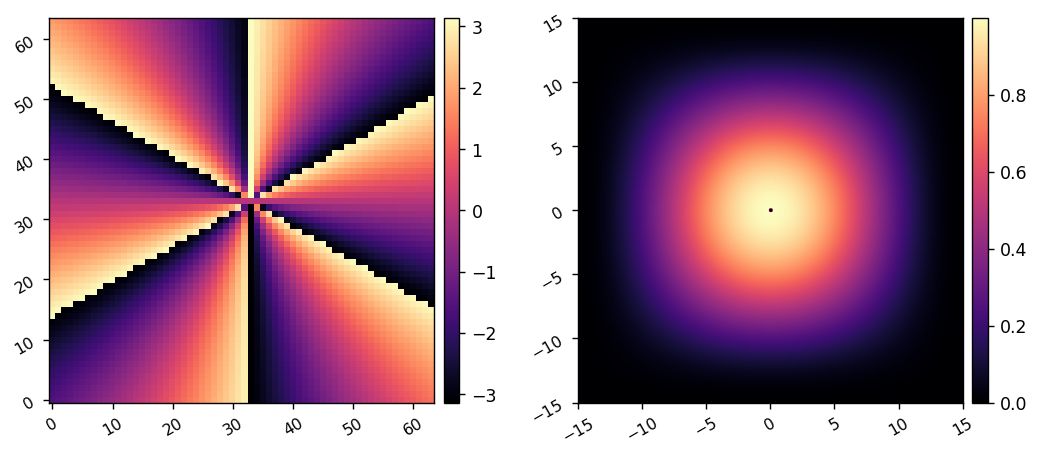

In [4]:
oversample_vortex = 4.096
N_vortex_lres = int(npix*oversample_vortex)
lres_sampling = 1/oversample_vortex # low resolution sampling in lam/D per pixel
lres_win_size = int(30/lres_sampling) + 1
w1d = xp.array(windows.tukey(lres_win_size, 1, False))
lres_window = utils.pad_or_crop(xp.outer(w1d, w1d), N_vortex_lres)
vortex_lres = props.make_vortex_phase_mask(N_vortex_lres)
imshow2(xp.angle(vortex_lres), 1-lres_window, npix1=64, npix2=lres_win_size, pxscl2=lres_sampling)

hres_sampling = 0.025 # lam/D per pixel; this value is chosen empirically
N_vortex_hres = int(np.round(30/hres_sampling))
hres_win_size = int(30/hres_sampling)
N_vortex_hres = int(np.round(30.029296875/hres_sampling))
hres_win_size = int(30.029296875/hres_sampling)
w1d = xp.array(windows.tukey(hres_win_size, 1, False))
hres_window = utils.pad_or_crop(xp.outer(w1d, w1d), N_vortex_hres)
vortex_hres = props.make_vortex_phase_mask(N_vortex_hres)

x = (xp.linspace(-N_vortex_hres//2, N_vortex_hres//2-1, N_vortex_hres)) * hres_sampling
x,y = xp.meshgrid(x,x)
r = xp.sqrt(x**2 + y**2)
sing_mask = r>=0.15
hres_window *= sing_mask
imshow2(xp.angle(vortex_hres), hres_window, npix1=64, npix2=hres_win_size, pxscl2=hres_sampling)

psf_pixelscale_lamD = 0.17
npsf = 200

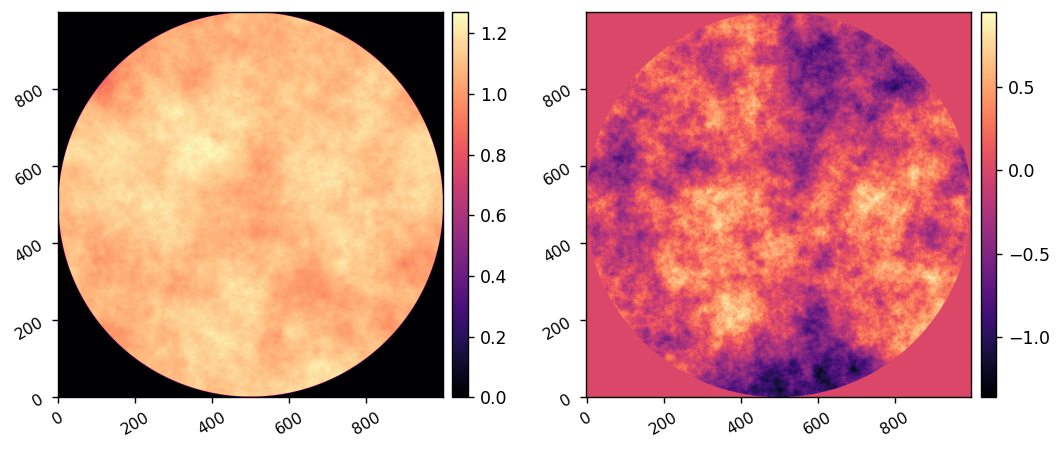

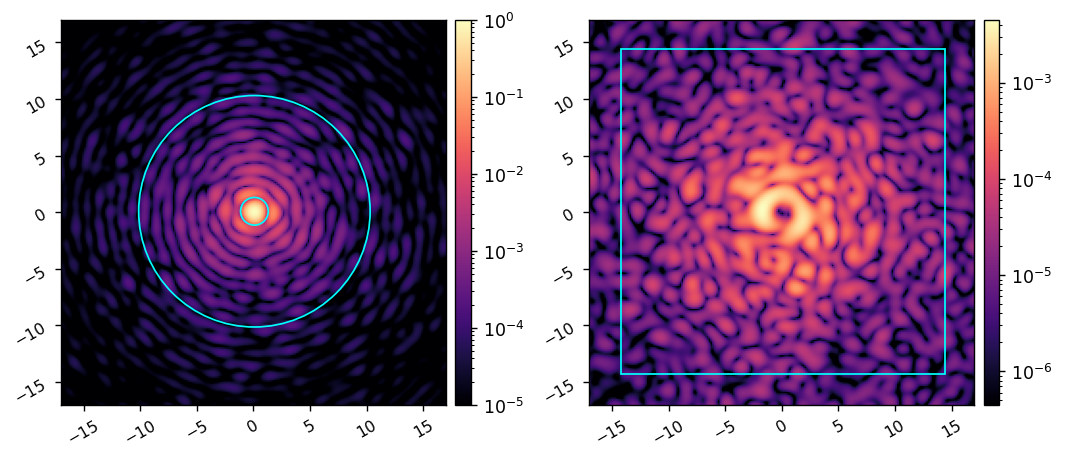

In [6]:
reload(props)
def forward_model(command, use_vortex=True, use_wfe=True, return_pupil=False):
    mft_command = Mx_dm@command@My_dm
    fourier_surf = fourier_inf_fun * mft_command
    # dm_surf = xp.fft.ifft2(fourier_surf).real
    dm_surf = xp.fft.ifftshift(xp.fft.ifft2(xp.fft.fftshift(fourier_surf,))).real

    dm_phasor = xp.exp(1j * 4*xp.pi/wavelength.to_value(u.m) * dm_surf)
    wf = utils.pad_or_crop(APERTURE, N).astype(xp.complex128)
    
    wf *= utils.pad_or_crop(dm_phasor, N)
    # imshow2(xp.abs(wf), xp.angle(wf), npix=npix)

    if use_wfe: 
        wf *= utils.pad_or_crop(WFE, N)
        # imshow2(xp.abs(wf), xp.angle(wf), npix=npix)

    if return_pupil:
        E_pup = copy.copy(wf)

    if use_vortex:
        lres_wf = utils.pad_or_crop(wf, N_vortex_lres) # pad to the larger array for the low res propagation
        fp_wf_lres = xp.fft.ifftshift(xp.fft.fft2(xp.fft.fftshift(lres_wf))) # to FPM
        fp_wf_lres *= vortex_lres * (1 - lres_window) # apply low res (windowed) FPM
        pupil_wf_lres = xp.fft.fftshift(xp.fft.ifft2(xp.fft.ifftshift(fp_wf_lres))) # to Lyot Pupil
        # pupil_wf_lres = utils.pad_or_crop(pupil_wf_lres, N)

        hres_wf = utils.pad_or_crop(wf, npix) # crop to the pupil diameter for the high res propagation
        fp_wf_hres = props.mft_forward(hres_wf, hres_sampling, N_vortex_hres)
        fp_wf_hres *= vortex_hres * hres_window # apply high res (windowed) FPM
        # pupil_wf_hres = props.mft_reverse(fp_wf_hres, hres_sampling, npix,)
        # pupil_wf_hres = utils.pad_or_crop(pupil_wf_hres, N)
        pupil_wf_hres = props.mft_reverse(fp_wf_hres, hres_sampling*oversample_vortex, N_vortex_lres,)

        wf = (pupil_wf_lres + pupil_wf_hres)
        wf = utils.pad_or_crop(wf, N)
        # imshow2(xp.abs(wf), xp.angle(wf))

    wf *= utils.pad_or_crop(LYOT, N)
    # imshow2(xp.abs(wf), xp.angle(wf), npix=2*npix)

    wf = utils.pad_or_crop(wf, nlyot)
    fpwf = props.mft_forward(wf, psf_pixelscale_lamD, npsf)

    if return_pupil:
        return fpwf, E_pup
    else:
        return fpwf

command = xp.zeros((Nact,Nact))

# command = 10e-9 * xp.ones((Nact,Nact))
# command[1::2, ::2] *= -1
# command[::2, 1::2] *= -1

# waffle_command = 10e-9 * xp.ones((Nact,Nact))
# waffle_command[::2,::2] *= -1
# waffle_command[1::2, 1::2] = 0
# acts = ensure_np_array(waffle_command[dm_mask]) 

print()
psf_wf, E_pup = forward_model(command, 
                              use_vortex=False, 
                            #   use_wfe=False, 
                              return_pupil=True,
                              )
coro_wf = forward_model(command, 
                        # use_wfe=False,
                        )


psf = xp.abs(psf_wf)**2 
coro_im = xp.abs(coro_wf)**2
I_max_ref = xp.max(psf)

psf /= I_max_ref
coro_im /= I_max_ref

imshow2(xp.abs(E_pup), xp.angle(E_pup), npix=npix)
imshow2(psf, coro_im, 
        pxscl=psf_pixelscale_lamD, 
        patches1=[Circle((psf_pixelscale_lamD/2,psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((psf_pixelscale_lamD/2,psf_pixelscale_lamD/2), 10.22, fill=False, color='cyan')],
        patches2=[Rectangle((-crad+psf_pixelscale_lamD/2, -crad+psf_pixelscale_lamD/2), crad*2, crad*2, fill=False, color='cyan', )],
        lognorm=True, vmin1=1e-5, vmin2=xp.max(coro_im)/1e4)


# Test normal EFC

In [9]:
control_mask = create_control_mask(iwa=3, owa=12, edge=3, rotation=0)
Nmask = int(control_mask.sum())

poke_modes = xp.zeros((Nacts, Nact, Nact))
count = 0
for i in range(Nact):
    for j in range(Nact):
        if dm_mask[i,j]:
            poke_modes[count, i,j] = 1
            count += 1
# poke_modes = poke_modes[:,:].reshape(Nacts, Nact**2)

amp = 1e-9
jac = xp.zeros((2*Nmask, Nacts))
for i in range(Nacts):
    E_pos = forward_model(amp*poke_modes[i], use_wfe=True, use_vortex=True)[control_mask] / xp.sqrt(I_max_ref)
    E_neg = forward_model(-amp*poke_modes[i], use_wfe=True, use_vortex=True)[control_mask] / xp.sqrt(I_max_ref)
    response = (E_pos - E_neg)/(2*amp)
    jac[::2,i] = xp.real(response)
    jac[1::2,i] = xp.imag(response)



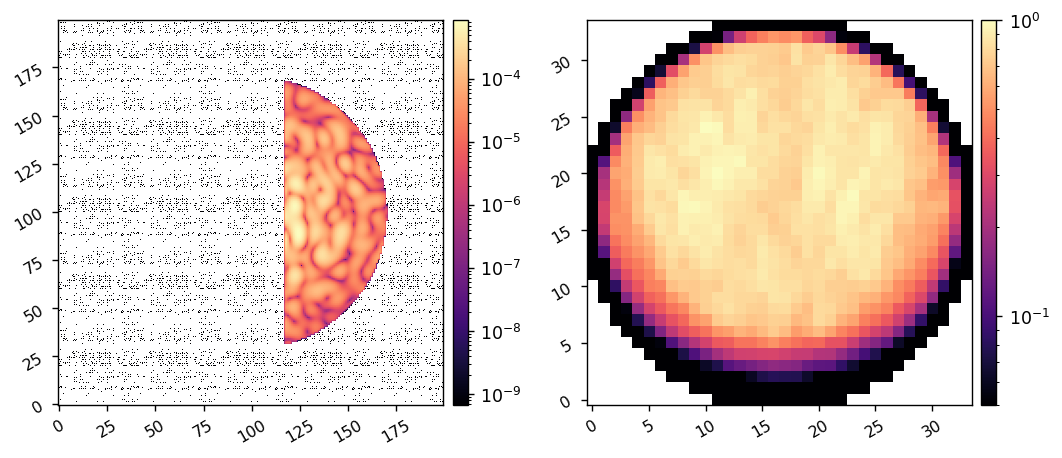

In [10]:
responses = jac[::2] + 1j*jac[1::2]
dm_response = xp.sqrt(xp.sum(xp.square(xp.abs(responses.dot(poke_modes.reshape(Nacts, Nact**2)))), axis=0)).reshape(Nact,Nact)
dm_response /= dm_response.max()
imshow2(control_mask*coro_im, dm_response, lognorm=True, vmin2=5e-2)

In [8]:
def beta_reg(S, beta=-1):
    # S is the sensitivity matrix also known as the Jacobian
    sts = xp.matmul(S.T, S)
    rho = xp.diag(sts)
    alpha2 = rho.max()

    control_matrix = xp.matmul( xp.linalg.inv( sts + alpha2*10.0**(beta)*xp.eye(sts.shape[0]) ), S.T)
    return control_matrix

def efc(Nitr=3, 
        nominal_command=xp.zeros((Nact,Nact)), 
        gain=0.5, 
        all_ims=None, 
        all_efs=None,
        all_commands=None,
        ):
    
    metric_images = [] if all_ims is None else all_ims
    ef_estimates = [] if all_efs is None else all_efs
    dm_commands = [] if all_commands is None else all_commands
    starting_itr = len(metric_images)

    total_command = copy.copy(nominal_command)
    del_command = xp.zeros((Nact,Nact))
    E_ab = xp.zeros(2*Nmask)
    for i in range(Nitr):
        E_est = forward_model(total_command, use_vortex=True, use_wfe=True,) / xp.sqrt(I_max_ref)
        E_ab[::2] = E_est.real[control_mask]
        E_ab[1::2] = E_est.imag[control_mask]

        del_acts = -gain * cm.dot(E_ab)
        del_command[dm_mask] = del_acts
        total_command += del_command
        image_ni = xp.abs(forward_model(total_command, use_vortex=True, use_wfe=True))**2 / I_max_ref

        mean_ni = xp.mean(image_ni[control_mask])

        metric_images.append(copy.copy(image_ni))
        ef_estimates.append(copy.copy(E_ab))
        dm_commands.append(copy.copy(total_command))

        imshow3(del_command, total_command, image_ni, 
                f'Iteration {starting_itr + i + 1:d}: $\delta$DM', 
                'Total DM Command', 
                f'Image\nMean NI = {mean_ni:.3e}',
                cmap1='viridis', cmap2='viridis', 
                pxscl3=psf_pixelscale_lamD, lognorm3=True, vmin3=1e-9)

    return metric_images, ef_estimates, dm_commands

In [9]:
all_ims = []
all_efs = []
all_commands = []

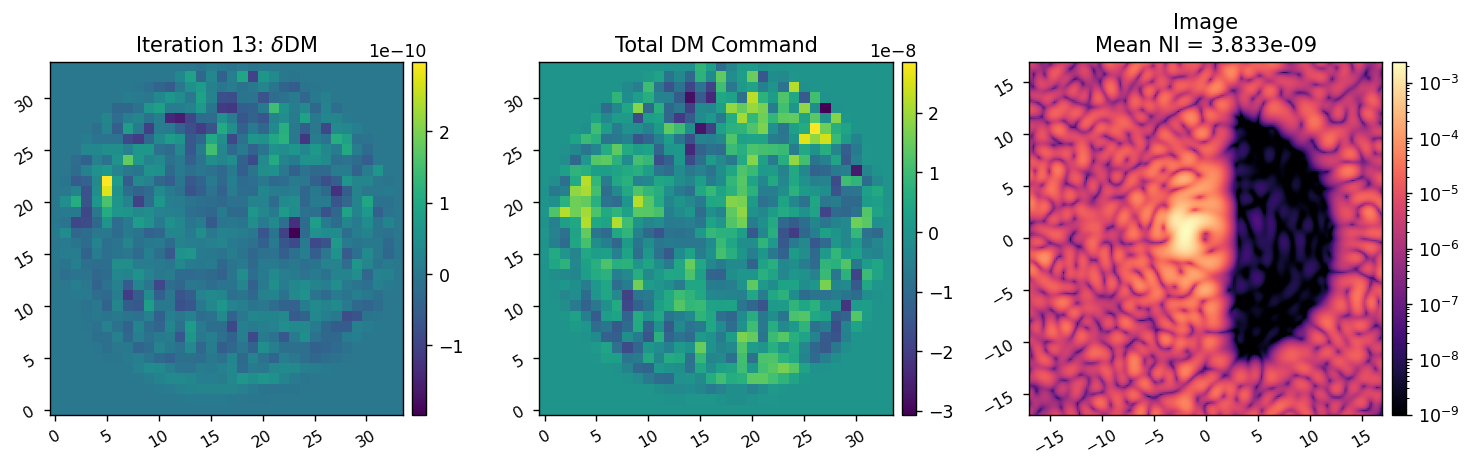

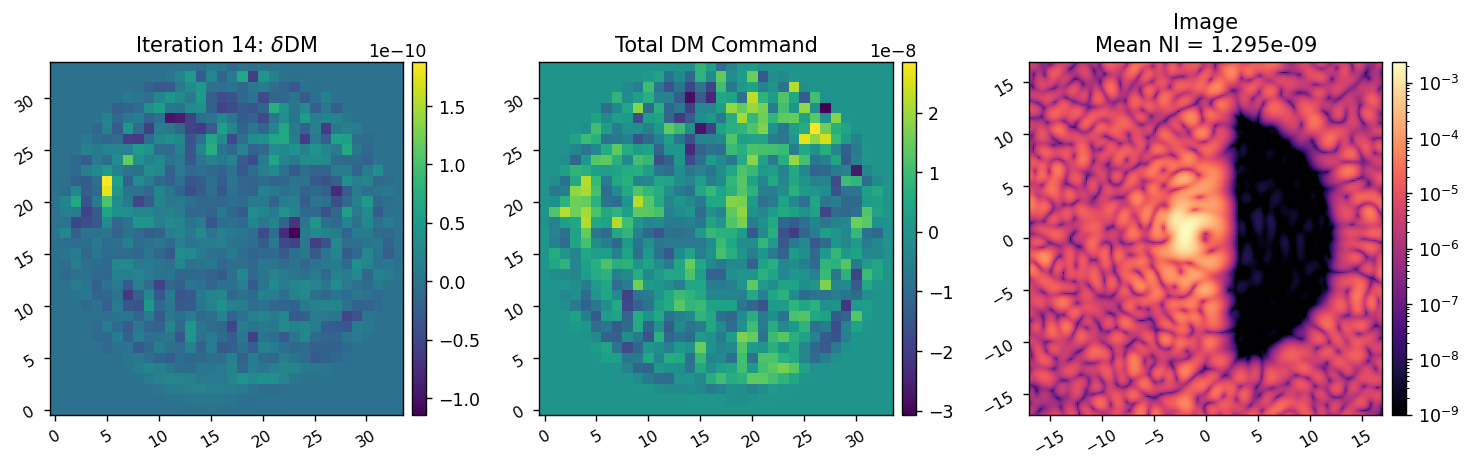

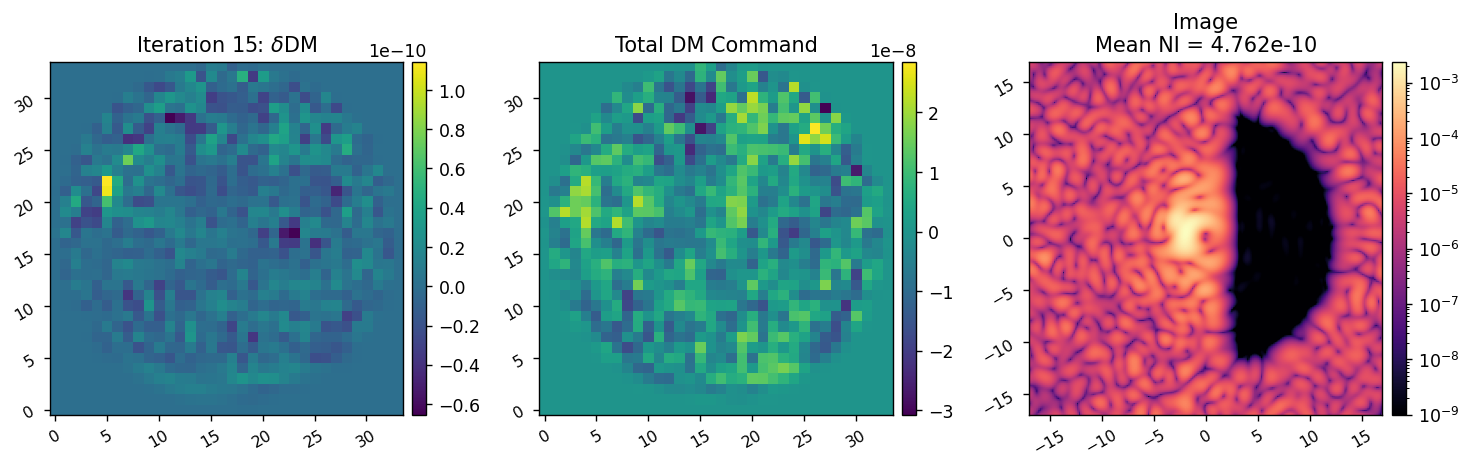

In [14]:
cm = beta_reg(jac, -2.5)
# cm = beta_reg(jac, -4.5)

all_ims, all_efs, all_commands = efc(Nitr=3, 
                                     nominal_command=all_commands[-1], 
                                     all_ims=all_ims, 
                                     all_efs=all_efs,
                                     all_commands=all_commands,
                                     )



# Create the adjoint model to back propagate 

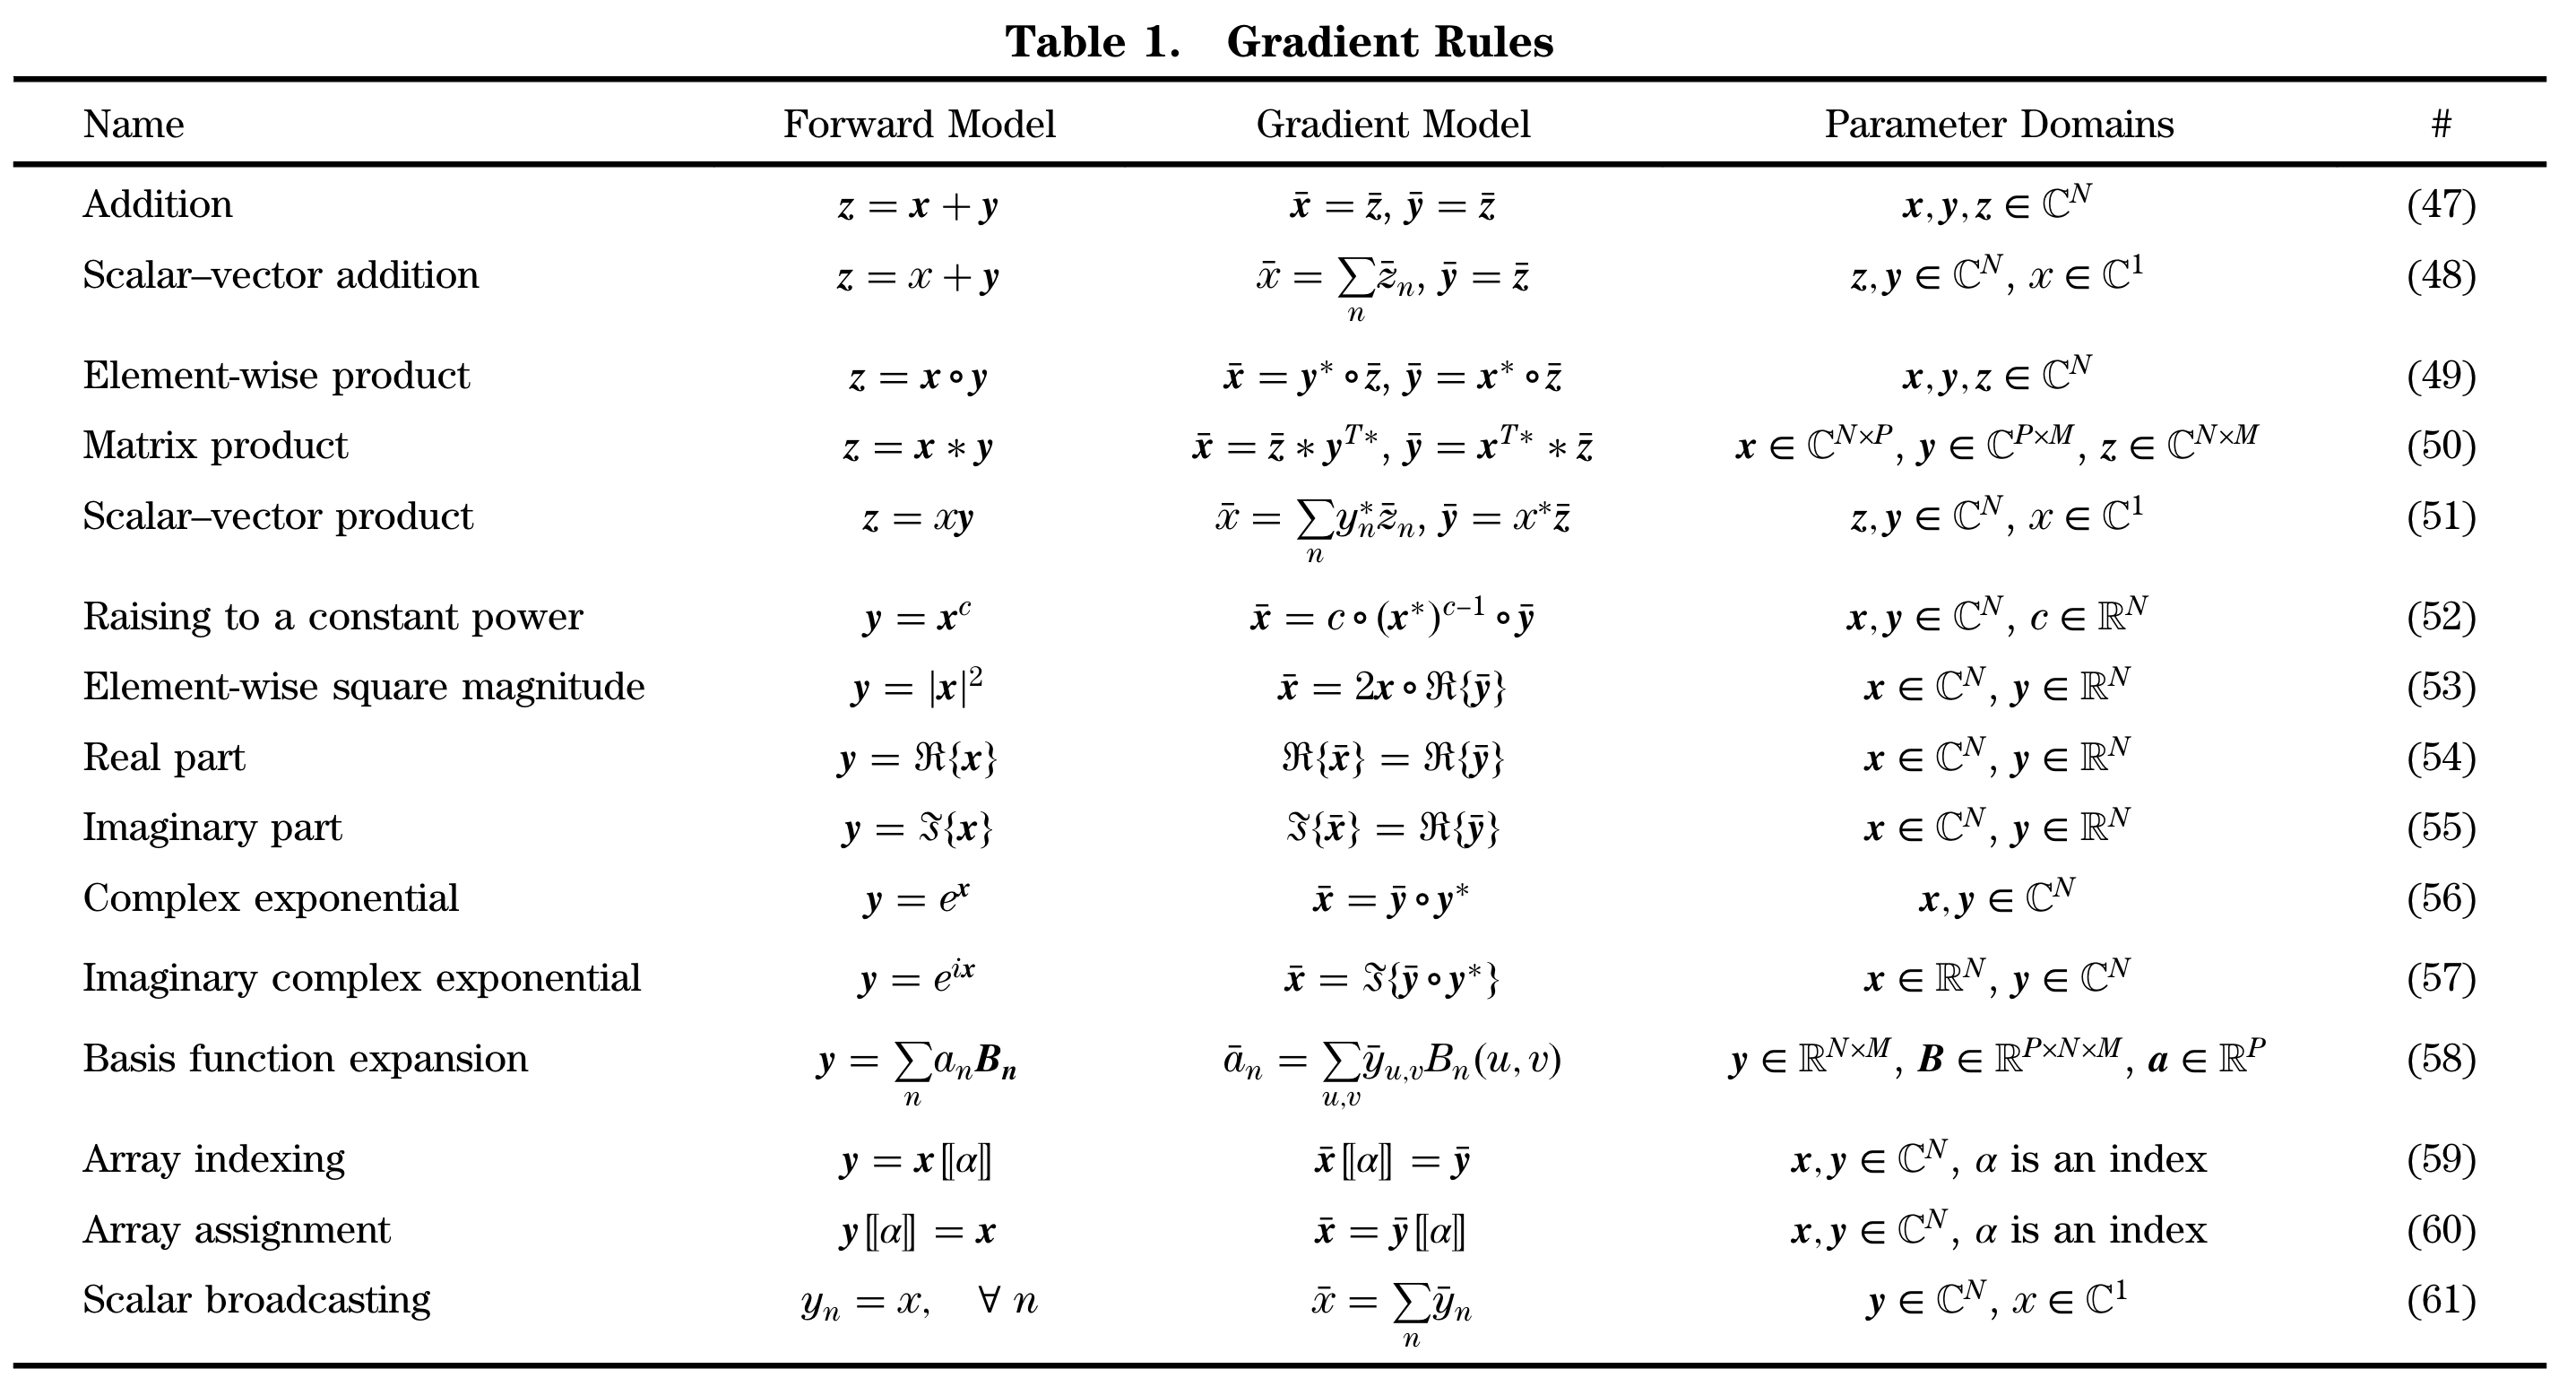

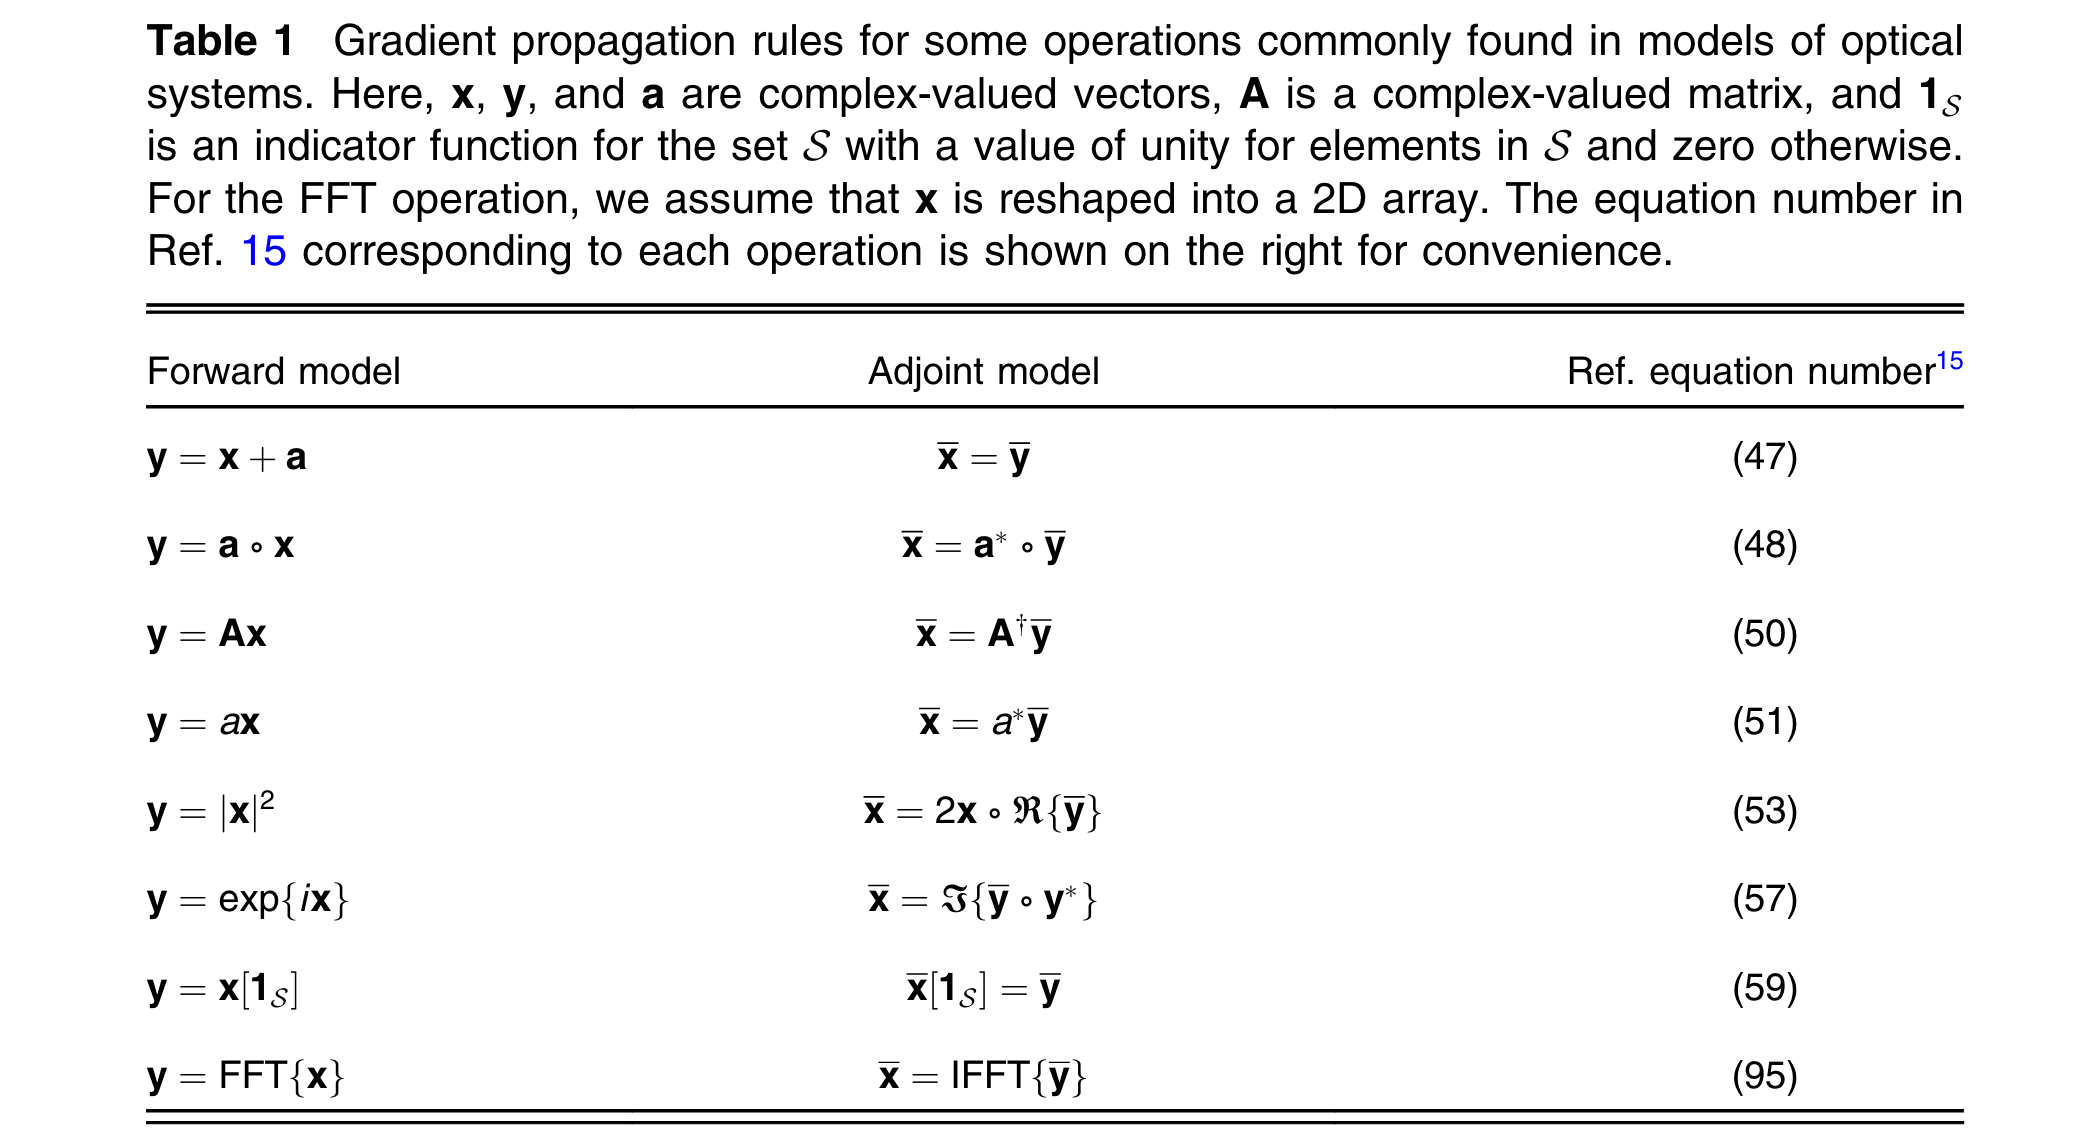

# Test minimzation with L-BFGS-B

In [26]:
def val_and_grad(del_acts, E_ab, E_target=0, E_model_nom=0, r_cond=1e-2, plot=False):
    # Convert array arguments into GPU arrays if necessary
    E_ab = xp.array(E_ab) 
    E_target = xp.array(E_target)
    E_model_nom= xp.array(E_model_nom)
    
    E_ab_l2norm = E_ab[control_mask].dot(E_ab[control_mask].conjugate()).real

    # Compute E_dm using the forward DM model
    del_command = xp.zeros((Nact,Nact))
    del_command[dm_mask] = xp.array(del_acts)
    E_dm = forward_model(del_command, use_vortex=True, use_wfe=False) / xp.sqrt(I_max_ref) # make sure to do the array indexing
    E_dm = E_dm - E_model_nom

    # compute the cost function
    delE = E_ab + E_dm - E_target
    delE_vec = delE[control_mask] # make sure to do array indexing
    J_delE = delE_vec.dot(delE_vec.conjugate()).real
    M_tik = r_cond * np.eye(Nacts, Nacts)
    c = M_tik.dot(del_acts) # I think I am doing something wrong with M_tik
    J_c = c.dot(c)
    J = (J_delE + J_c) / E_ab_l2norm
    print(J_delE, J_c, E_ab_l2norm, J)

    # Compute the gradient with the adjoint model
    delE_masked = control_mask * delE # still a 2D array
    dJ_dE_dm = 2 * delE_masked / E_ab_l2norm
    dJ_dE_ls = props.mft_reverse(dJ_dE_dm, psf_pixelscale_lamD, nlyot)
    dJ_dE_ls = utils.pad_or_crop(dJ_dE_ls, npix)
    dJ_dE_lp = LYOT * dJ_dE_ls
    # imshow2(xp.abs(dJ_dE_lp), xp.angle(dJ_dE_lp))

    # Now we have to split and back-propagate the gradient along the two branches 
    # used to model the vortex. So one branch for the FFT vortex procedure and one 
    # for the MFT vortex procedure. 
    dJ_dE_lp_fft = utils.pad_or_crop(copy.copy(dJ_dE_lp), N_vortex_lres)
    dJ_dE_fpm_fft = xp.fft.fftshift(xp.fft.fft2(xp.fft.ifftshift(dJ_dE_lp_fft)))
    dJ_dE_fp_fft = vortex_lres.conjugate() * (1 - lres_window) * dJ_dE_fpm_fft
    dJ_dE_pup_fft = xp.fft.ifftshift(xp.fft.ifft2(xp.fft.fftshift(dJ_dE_fp_fft)))
    dJ_dE_pup_fft = utils.pad_or_crop(dJ_dE_pup_fft, N)
    # imshow2(xp.abs(dJ_dE_pup_fft), xp.angle(dJ_dE_pup_fft), npix=1*npix)

    dJ_dE_lp_mft = utils.pad_or_crop(copy.copy(dJ_dE_lp), N_vortex_lres)
    dJ_dE_fpm_mft = props.mft_forward(dJ_dE_lp_mft, hres_sampling*oversample_vortex, N_vortex_hres)
    # dJ_dE_lp_mft = utils.pad_or_crop(copy.copy(dJ_dE_lp), nlyot)
    # dJ_dE_fpm_mft = props.mft_forward(dJ_dE_lp_mft, hres_sampling, N_vortex_hres)
    dJ_dE_fp_mft = vortex_hres.conjugate() * hres_window * dJ_dE_fpm_mft
    # dJ_dE_pup_mft = props.mft_reverse(dJ_dE_fp_mft, hres_sampling, npix,)
    dJ_dE_pup_mft = props.mft_reverse(dJ_dE_fp_mft, hres_sampling*oversample, N,)
    # dJ_dE_pup_mft = utils.pad_or_crop(dJ_dE_pup_mft, N)
    # imshow2(xp.abs(dJ_dE_pup_mft), xp.angle(dJ_dE_pup_mft), npix=1*npix)

    dJ_dE_pup = dJ_dE_pup_fft + dJ_dE_pup_mft
    # imshow2(xp.abs(dJ_dE_pup), xp.angle(dJ_dE_pup), npix=1*npix)

    dJ_dS_dm = 4*xp.pi / wavelength.to_value(u.m) * xp.imag(E_pup.conjugate()/xp.sqrt(I_max_ref) * dJ_dE_pup)

    # Now pad back to the array size fo the DM surface to back propagate through the adjoint DM model
    dJ_dS_dm = utils.pad_or_crop(dJ_dS_dm, Nsurf) 
    # x1_bar = fourier_inf_fun.conjugate() * xp.fft.fft2(dJ_dS_dm)
    x1_bar = fourier_inf_fun.conjugate() * xp.fft.ifftshift(xp.fft.fft2(xp.fft.fftshift(dJ_dS_dm,)))
    dJ_dA = Mx_dm_back@x1_bar@My_dm_back / xp.sum(xp.abs(Mx_dm_back))**2
    dJ_dA = dJ_dA[dm_mask]
    
    return ensure_np_array(J), ensure_np_array(dJ_dA).real

0.3527079193215589 0.0 0.3527079193215589 1.0


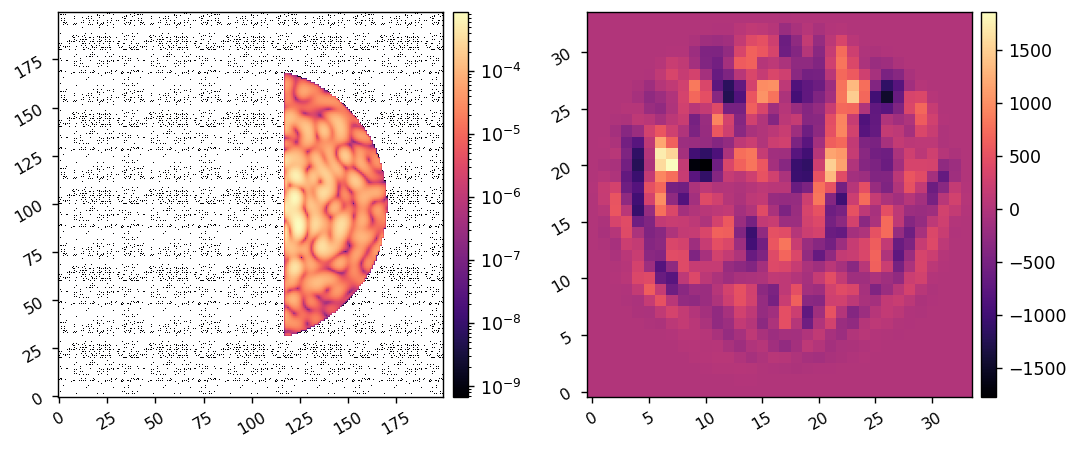

In [29]:
control_mask = create_control_mask(iwa=3, owa=12, edge=3, rotation=0)

del_acts = np.zeros(Nacts)
E_ab = ensure_np_array(forward_model(xp.zeros((Nact,Nact)), use_vortex=True, use_wfe=True) * control_mask / xp.sqrt(I_max_ref))
E_target = 0
E_model_nom = ensure_np_array(forward_model(xp.zeros((Nact,Nact)), use_vortex=True, use_wfe=False) / xp.sqrt(I_max_ref))
r_cond = 1e-2

J, dJ_dA = val_and_grad(del_acts, 
                        E_ab,
                        E_target=E_target, 
                        E_model_nom=E_model_nom,
                        r_cond=r_cond,
                        )

dm_grad = xp.zeros((Nact,Nact))
dm_grad[dm_mask] = dJ_dA
imshow2(control_mask*coro_im, dm_grad, lognorm1=True)

# Does E_ep_k-1 contain the wavefront contribution from the total accumulated DM command?

In [28]:
del_acts = np.zeros(Nacts)
E_ab = ensure_np_array(forward_model(xp.zeros((Nact,Nact)), use_vortex=True, use_wfe=True) * control_mask / xp.sqrt(I_max_ref))
E_target = 0
E_model_nom = ensure_np_array(forward_model(xp.zeros((Nact,Nact)), use_vortex=True, use_wfe=False) / xp.sqrt(I_max_ref))
r_cond = 1e-2

bfgs_tol = 1e-3
bfgs_opts = {
    'maxiter':20,
    # 'maxls':30, # default is 20
    'ftol':1e-6, 
    'gtol':1e-6,
    'disp':True, 
}

res = minimize(val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(E_ab, E_target, E_model_nom, r_cond), 
                method='L-BFGS-B',
                #    method='CG',
                tol=bfgs_tol,
                options=bfgs_opts,
                )
    

0.3527079193215589 0.0 0.3527079193215589 1.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.


ValueError: failed in converting 7th argument `g' of _lbfgsb.setulb to C/Fortran array

# Test a full EFC run with L-BFGS-B

In [20]:
def ad_efc(Nitr=3, 
        nominal_command=xp.zeros((Nact,Nact)), 
        gain=0.5, 
        all_ims=None, 
        all_efs=None,
        all_commands=None,
        ):
    
    metric_images = [] if all_ims is None else all_ims
    ef_estimates = [] if all_efs is None else all_efs
    dm_commands = [] if all_commands is None else all_commands
    starting_itr = len(metric_images)

    total_command = copy.copy(nominal_command)
    del_command = xp.zeros((Nact,Nact))
    E_ab = xp.zeros(2*Nmask)
    for i in range(Nitr):
        E_ab = forward_model(total_command, use_vortex=True, use_wfe=True,) / xp.sqrt(I_max_ref)
        
        res = minimize(val_and_grad, 
                        jac=True, 
                        x0=del_acts0,
                        args=(E_ab, E_target, E_model_nom, r_cond), 
                        method='L-BFGS-B',
                        #    method='CG',
                        tol=bfgs_tol,
                        options=bfgs_opts,
                        )

        del_acts = gain * res.result
        del_command[dm_mask] = del_acts
        total_command += del_command
        image_ni = xp.abs(forward_model(total_command, use_vortex=True, use_wfe=True))**2 / I_max_ref

        mean_ni = xp.mean(image_ni[control_mask])

        metric_images.append(copy.copy(image_ni))
        ef_estimates.append(copy.copy(E_ab))
        dm_commands.append(copy.copy(total_command))

        imshow3(del_command, total_command, image_ni, 
                f'Iteration {starting_itr + i + 1:d}: $\delta$DM', 
                'Total DM Command', 
                f'Image\nMean NI = {mean_ni:.3e}',
                cmap1='viridis', cmap2='viridis', 
                pxscl3=psf_pixelscale_lamD, lognorm3=True, vmin3=1e-9)

    return metric_images, ef_estimates, dm_commands